# Test Global Model Inference
Test predictions using the trained global model

In [1]:
import joblib
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

## Load Model & Encoder

In [2]:
MODEL_PATH = '/home/cosc-admin/the-project-maverick/model_artifacts_global/global_model.json'
ENCODER_PATH = '/home/cosc-admin/the-project-maverick/model_artifacts_global/ticker_encoder.joblib'

# Load model
model = XGBRegressor()
model.load_model(MODEL_PATH)
print(f"Model loaded: {model.n_estimators} estimators")

# Load ticker encoder
ticker_encoder = joblib.load(ENCODER_PATH)
print(f"Encoder loaded: {len(ticker_encoder.classes_)} tickers")
print(f"Sample tickers: {list(ticker_encoder.classes_[:10])}")

Model loaded: None estimators
Encoder loaded: 514 tickers
Sample tickers: [np.str_('a'), np.str_('aapl'), np.str_('abbv'), np.str_('abnb'), np.str_('abt'), np.str_('acgl'), np.str_('acn'), np.str_('adbe'), np.str_('adi'), np.str_('adm')]


## Database Connection

In [3]:
DB_CONFIG = {
    'host': 'localhost',
    'port': 5432,
    'database': 'market_data',
    'user': 'mluser',
    'password': 'mlpassword'
}

engine = create_engine(f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}")
print("Connected to database")

Connected to database


## Feature Engineering Function

In [4]:
PREDICTION_HORIZON = 60  # Must match training

def create_features_for_inference(df, ticker_id):
    """
    Create features for inference (same as training).
    Returns features for the LAST row (most recent data point).
    """
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)
    
    # Returns
    for lag in [1, 5, 10, 20]:
        df[f'ret_{lag}'] = df['close'].pct_change(lag)
    
    # Moving Averages
    for window in [10, 50]:
        df[f'sma_{window}'] = df['close'].rolling(window=window).mean()
        df[f'dist_sma_{window}'] = df['close'] / df[f'sma_{window}'] - 1
        
    # Volatility
    df['volatility_20'] = df['ret_1'].rolling(window=20).std()
    
    # RSI
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / (loss + 1e-8)
    df['rsi'] = 100 - (100 / (1 + rs))
    
    # Volume
    df['vol_ma_20'] = df['volume'].rolling(window=20).mean()
    df['vol_ratio'] = df['volume'] / (df['vol_ma_20'] + 1)
    
    # Time Features
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    
    # Ticker ID
    df['ticker_id'] = ticker_id
    
    # Feature columns (must match training order)
    feature_cols = [
        'ticker_id', 'hour', 'dayofweek',
        'ret_1', 'ret_5', 'ret_10', 'ret_20',
        'dist_sma_10', 'dist_sma_50',
        'volatility_20', 'rsi', 'vol_ratio'
    ]
    
    # Drop NaN rows
    df = df.dropna().reset_index(drop=True)
    
    return df[feature_cols], df['close'], df['date']

## Predict for a Single Stock

In [5]:
def predict_stock(ticker):
    """Make prediction for a single stock."""
    # Load data
    query = f'SELECT date, open, high, low, close, volume FROM market."{ticker}" ORDER BY date'
    with engine.connect() as conn:
        df = pd.read_sql(query, conn)
    
    # Get ticker ID
    ticker_id = ticker_encoder.transform([ticker])[0]
    
    # Create features
    X, prices, dates = create_features_for_inference(df, ticker_id)
    
    # Predict returns
    predicted_returns = model.predict(X)
    
    # Convert to predicted prices
    predicted_prices = prices.values * (1 + predicted_returns)
    
    return {
        'dates': dates,
        'actual_prices': prices,
        'predicted_returns': predicted_returns,
        'predicted_prices': predicted_prices
    }

In [6]:
# Test with AAPL
ticker = 'aapl'
results = predict_stock(ticker)

print(f"=== {ticker.upper()} Predictions ===")
print(f"Data points: {len(results['dates'])}")
print(f"Date range: {results['dates'].iloc[0]} to {results['dates'].iloc[-1]}")
print(f"\nLatest:")
print(f"  Date: {results['dates'].iloc[-1]}")
print(f"  Current Price: ${results['actual_prices'].iloc[-1]:.2f}")
print(f"  Predicted Return: {results['predicted_returns'][-1]*100:.4f}%")
print(f"  Predicted Price (in 5hrs): ${results['predicted_prices'][-1]:.2f}")

=== AAPL Predictions ===
Data points: 215911
Date range: 2023-07-03 06:05:00 to 2025-10-24 19:55:00

Latest:
  Date: 2025-10-24 19:55:00
  Current Price: $263.00
  Predicted Return: 0.0347%
  Predicted Price (in 5hrs): $263.09


## Backtest: Compare Predictions vs Actual

In [7]:
def backtest_stock(ticker, horizon=60):
    """Backtest predictions against actual future prices."""
    query = f'SELECT date, open, high, low, close, volume FROM market."{ticker}" ORDER BY date'
    with engine.connect() as conn:
        df = pd.read_sql(query, conn)
    
    ticker_id = ticker_encoder.transform([ticker])[0]
    X, prices, dates = create_features_for_inference(df, ticker_id)
    
    # Predict
    predicted_returns = model.predict(X)
    
    # Actual future returns (shifted)
    actual_future_prices = prices.shift(-horizon)
    actual_returns = actual_future_prices / prices - 1
    
    # Create comparison dataframe
    comparison = pd.DataFrame({
        'date': dates,
        'price': prices,
        'predicted_return': predicted_returns,
        'actual_return': actual_returns
    }).dropna()
    
    return comparison

In [8]:
# Backtest AAPL
ticker = 'aapl'
bt = backtest_stock(ticker)

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(bt['actual_return'], bt['predicted_return']))
mae = mean_absolute_error(bt['actual_return'], bt['predicted_return'])

# Direction accuracy
direction_correct = ((bt['predicted_return'] > 0) == (bt['actual_return'] > 0)).mean()

print(f"=== {ticker.upper()} Backtest Results ===")
print(f"RMSE: {rmse:.6f} ({rmse*100:.4f}%)")
print(f"MAE:  {mae:.6f} ({mae*100:.4f}%)")
print(f"Direction Accuracy: {direction_correct*100:.2f}%")

=== AAPL Backtest Results ===
RMSE: 0.007098 (0.7098%)
MAE:  0.004327 (0.4327%)
Direction Accuracy: 51.17%


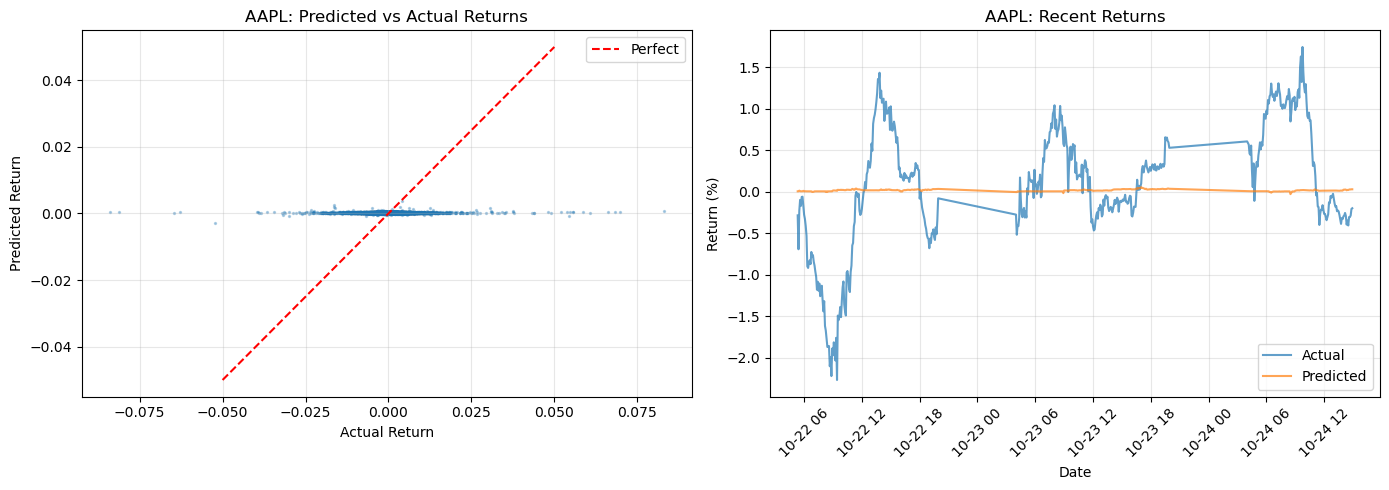

In [9]:
# Plot predicted vs actual returns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
ax1 = axes[0]
sample = bt.sample(min(5000, len(bt)))
ax1.scatter(sample['actual_return'], sample['predicted_return'], alpha=0.3, s=2)
ax1.plot([-0.05, 0.05], [-0.05, 0.05], 'r--', label='Perfect')
ax1.set_xlabel('Actual Return')
ax1.set_ylabel('Predicted Return')
ax1.set_title(f'{ticker.upper()}: Predicted vs Actual Returns')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Time series (last 500 points)
ax2 = axes[1]
recent = bt.tail(500)
ax2.plot(recent['date'], recent['actual_return']*100, label='Actual', alpha=0.7)
ax2.plot(recent['date'], recent['predicted_return']*100, label='Predicted', alpha=0.7)
ax2.set_xlabel('Date')
ax2.set_ylabel('Return (%)')
ax2.set_title(f'{ticker.upper()}: Recent Returns')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Test Multiple Stocks

In [10]:
test_tickers = ['aapl', 'msft', 'googl', 'amzn', 'tsla', 'nvda', 'meta']

results_all = []
for ticker in test_tickers:
    try:
        bt = backtest_stock(ticker)
        rmse = np.sqrt(mean_squared_error(bt['actual_return'], bt['predicted_return']))
        mae = mean_absolute_error(bt['actual_return'], bt['predicted_return'])
        direction = ((bt['predicted_return'] > 0) == (bt['actual_return'] > 0)).mean()
        
        results_all.append({
            'ticker': ticker.upper(),
            'rmse': rmse,
            'mae': mae,
            'direction_acc': direction
        })
    except Exception as e:
        print(f"Error with {ticker}: {e}")

results_df = pd.DataFrame(results_all)
print("\n=== Multi-Stock Backtest Results ===")
print(results_df.to_string(index=False))
print(f"\nAverage Direction Accuracy: {results_df['direction_acc'].mean()*100:.2f}%")


=== Multi-Stock Backtest Results ===
ticker     rmse      mae  direction_acc
  AAPL 0.007098 0.004327       0.511733
  MSFT 0.006549 0.004143       0.522756
 GOOGL 0.008089 0.005020       0.528461
  AMZN 0.008149 0.005125       0.517620
  TSLA 0.014437 0.009458       0.514879
  NVDA 0.012076 0.007904       0.531230
  META 0.009865 0.006065       0.519624

Average Direction Accuracy: 52.09%


## Make Live Prediction

In [11]:
def get_latest_prediction(ticker):
    """Get prediction for the most recent data point."""
    results = predict_stock(ticker)
    
    latest_idx = -1
    current_price = results['actual_prices'].iloc[latest_idx]
    pred_return = results['predicted_returns'][latest_idx]
    pred_price = results['predicted_prices'][latest_idx]
    
    return {
        'ticker': ticker.upper(),
        'date': results['dates'].iloc[latest_idx],
        'current_price': current_price,
        'predicted_return_pct': pred_return * 100,
        'predicted_price': pred_price,
        'direction': 'UP' if pred_return > 0 else 'DOWN'
    }

# Get predictions for top stocks
print("=" * 60)
print("LATEST PREDICTIONS (5-hour ahead)")
print("=" * 60)

for ticker in ['aapl', 'msft', 'googl', 'tsla', 'nvda']:
    pred = get_latest_prediction(ticker)
    print(f"\n{pred['ticker']}:")
    print(f"  Current: ${pred['current_price']:.2f}")
    print(f"  Predicted: ${pred['predicted_price']:.2f} ({pred['predicted_return_pct']:+.4f}%)")
    print(f"  Direction: {pred['direction']}")

LATEST PREDICTIONS (5-hour ahead)

AAPL:
  Current: $263.00
  Predicted: $263.09 (+0.0347%)
  Direction: UP

MSFT:
  Current: $524.27
  Predicted: $524.45 (+0.0342%)
  Direction: UP

GOOGL:
  Current: $260.00
  Predicted: $260.09 (+0.0349%)
  Direction: UP

TSLA:
  Current: $433.71
  Predicted: $433.87 (+0.0361%)
  Direction: UP

NVDA:
  Current: $186.46
  Predicted: $186.52 (+0.0339%)
  Direction: UP
